# Identification, aggregation and analysis of complexes in the Protein Data Bank

## Disclaimer

This Jupyter notebook is supplementary material for the publication:

**"Identification, aggregation and analysis of complexes in the Protein Data Bank"**, Sri A et al., BioRxiv

The code in this notebook reproduces the analysis presented in the publication.

## Background

Macromolecular complexes are crucial functional units in virtually all cellular processes. Their atomic-level understanding is vital to understanding molecular mechanisms and affects applications, such as developing new therapeutics. The Protein Data Bank (PDB) is the central repository for experimentally determined macromolecular structures. However, it can be challenging to find all instances that represent the same assembly in the PDB due to the current PDB annotation practices, which do not include the annotation of assemblies. This study highlights the importance of annotations for macromolecular complexes and the need for more robust methods to identify and classify these complexes across the PDB. We propose a new approach that uses external resources such as the Complex Portal and Gene Ontology to describe assemblies accurately and put them into their biological contexts. We anticipate that the new approach to identifying and classifying complexes will improve the usability and utility of the PDB for researchers in the field of structural biology and drug discovery.

### Primary use case of this Jupyter notebook

This notebook demonstrates how to extract assembly information from the data generated by the weekly-updated complex identifier process of PDBe.
Using this notebook, or by slightly editing the code presented here, it is easy to identify assemblies such as:

* Protein-only assemblies
* Assemblies containing RNA or DNA
* Assemblies with components unmapped to UniProt (e.g. antibodies)

## Importing dependencies

This code imports several modules that are used in the script.

* The `pandas` module is used for data manipulation and analysis
* `utility` is a custom module that contains utility functions used in the script
* `matplotlib` is a plotting library and `pyplot` is a sublibrary within it, often used for creating static, two-dimensional plots.
* `constants` is a custom module that contains constants used in the script. `UNIPROT_PATTERN` and `RFAM_PATTERN` are constants that are defined in the constants module and used in the script.

In [1]:
import pandas as pd
import numpy as np
import scripts.utility as ui
from matplotlib import pyplot as plt
from scripts.constants import UNIPROT_PATTERN, RFAM_PATTERN, RIBOSOMES_RFAM_MAPPING

## Pre-Processing

This section contains some pre-processing that we need to do before analysing the data

In [2]:
# Read the CSV file containing the data on assemblies
df = pd.read_csv("data/assemblies_data.csv")
prefered_assemblies_dict = dict(zip(df['ASSEMBLIES'], df['PREFERED_ASSEMBLIES']))

In [3]:
# This method generates the preferred assemblies string
def get_prefered_assembly_str(assembly_str):
    prefered_assemblies = []
    assemblies = assembly_str.split(",")
    for assembly in assemblies:
        prefered_assembly = prefered_assemblies_dict.get(assembly)
        if prefered_assembly is True:
            prefered_assemblies.append(assembly)
    return ",".join(prefered_assemblies)

In [4]:
# Group the rows in dataframe based on the assembly string
df = df.astype(str).groupby('ASSEMBLY_STRING', sort=False).agg(lambda x: ','.join(x.unique())).reset_index()
# Drop the existing PREFERED_ASSEMBLIES col in the dataframe
df = df.drop('PREFERED_ASSEMBLIES', axis=1)

In [5]:
# Create a new column that shows the prefered assemblies string for each unique assembly composition
df["PREFERED_ASSEMBLIES"] = df["ASSEMBLIES"].apply(lambda x: get_prefered_assembly_str(x))

In [6]:
# Create a new column that indicates whether each unique assembly composition contains chimeric chains
df["hasChimericChains"] = df["ASSEMBLY_STRING"].apply(lambda x: ui.check_for_chimeric_chains(x))
# Exclude unique assemblies that contain chimeric chains
df = df[df["hasChimericChains"] == False]

## Assembly Classification

We can classify the assemblies into three types:
* monomeric
* homomeric
* heteromeric

A monomeric assembly is defined as an assembly that consists of a single subunit. Homomeric assemblies are formed by repeated units of a single subunit while heteromeric assemblies are composed of multiple distinct subunits. 

In [7]:
df["ASSEMBLY_TYPE"] = df["ASSEMBLY_STRING"].apply(lambda x: ui.get_assembly_type(x))

## 1) Assemblies analysis

This section contains some general analyses that were carried out on assemblies across the whole PDB archieve in order to learn their numbers, composition of the assemblies and how many components in the assemblies are mapped to external resources such as [UniProt](https://www.uniprot.org/) for protein entities and [Rfam](https://rfam.org/) for RNA entities

### 1.2) Basic statistics

#### 1.2.1) Unique assemblies

First, we check how many unique assembly compositions are there in the PDB.

In [8]:
print("There are %i unique assembly compositions in the Protein Data Bank." % len(df))

There are 97528 unique assembly compositions in the Protein Data Bank.


In [9]:
# Column to indicate the exp methods used to solved the structures of each unique assembly composition
df["EXP_METHOD"] = df["ASSEMBLIES"].apply(lambda x: ui.get_exp_methods(x))
exp_methods = df["EXP_METHOD"].value_counts().head(20)
exp_methods

X-ray                     77984
EM                         9369
NMR                        7902
NMR,X-ray                  1556
EM,X-ray                    470
Hybrid,X-ray                 53
Hybrid                       49
EM,NMR,X-ray                 41
EM,NMR                       19
Other,X-ray                  10
Hybrid,Other,X-ray           10
SAS                          10
Hybrid,NMR                    9
Hybrid,NMR,X-ray              9
SAS,X-ray                     5
NMR,Other,X-ray               5
Hybrid,NMR,Other,X-ray        5
Other                         5
EM,Hybrid,Other,X-ray         3
EM,Hybrid,NMR,X-ray           3
Name: EXP_METHOD, dtype: int64

In [10]:
# Column to indicate the species name for each unique assembly composition
df["SPECIES_NAME"] = df["ASSEMBLY_STRING"].apply(lambda x: ui.get_species_name(x))
df["SPECIES_NAME"].value_counts().head(10)

Humo sapiens                  16645
Escherichia coli               3721
transgenic mice                2940
Saccharomyces cerevisiae       2778
Thermus thermophilus           1154
Pseudomonas aeruginosa         1086
Mycobacterium tuberculosis     1050
Arabis thaliana                 995
Mus norvegicus                  989
Bacillus subtilis               900
Name: SPECIES_NAME, dtype: int64

#### 1.2.2) Unique assemblies containing proteins

Next, we look at how many of these unique assemblies contain proteins.

In [11]:
# Column to indicate the number of assemblies each unique assembly has
df["NUM_ASSEMBLIES"] = df["ASSEMBLIES"].apply(lambda x: ui.count_assemblies(x))

# Column to indicate the number of distinct PDBIDs each unique assembly has
df["NUM_PDB"] = df["ASSEMBLIES"].apply(lambda x: ui.count_unique_pdb(x))

# Column to indicate whether each unique assembly has a protein component
df["hasProteinComponent"] = df["ASSEMBLY_STRING"].apply(lambda x: ui.check_for_protein(x))

df[df["hasProteinComponent"] == True].head()

,ASSEMBLY_STRING,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING_WITH_UNP_NUMBERING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,hasChimericChains,ASSEMBLY_TYPE,EXP_METHOD,SPECIES_NAME,NUM_ASSEMBLIES,NUM_PDB,hasProteinComponent
0,A0A003_2,8314d71be12be24dca4d3578fa195f89,A0A003_2|1_340,PDB-CPX-100001,nan,NAD-dependent epimerase/dehydratase domain-con...,protein name from UniProt,"6kv9_1,6kvc_1","6kv9_1,6kvc_1",False,homomeric,X-ray,culture-collection:NRRL:B:12104 [[Streptomyces,2,2,True
1,"A0A009I821_1,A0A009L7S8_1,A0A014CLK2_1,A0A1V3D...",e063e8ace0bd49972940e0b8bd74783f,"A0A009I821_1|1_109,A0A009L7S8_1|1_103,A0A014CL...",PDB-CPX-100002,nan,70S ribosome and RNA,ribosome (non-Rfam),7m4w_1,7m4w_1,False,heteromeric,EM,Acinetobacter baumannii,1,1,True
2,"A0A009I821_1,A0A009L7S8_1,A0A022IPE7_1,A0A0Q7F...",e5f5ec1896d2d626e0a23b79be0155d3,"A0A009I821_1|1_109,A0A009L7S8_1|1_103,A0A022IP...",PDB-CPX-100003,nan,70S ribosome and RNA,ribosome (non-Rfam),7ryf_1,7ryf_1,False,heteromeric,EM,Acinetobacter baumannii,1,1,True
3,"A0A009I821_1,A0A009L7S8_1,A0A022IPE7_1,A0A0Q7F...",97679ef196cb670e86997624a5269abb,"A0A009I821_1|1_109,A0A009L7S8_1|1_103,A0A022IP...",PDB-CPX-100004,nan,70S ribosome and RNA,ribosome (non-Rfam),7ryg_1,7ryg_1,False,heteromeric,EM,Acinetobacter baumannii,1,1,True
4,"A0A009I821_1,A0A009L7S8_1,A0A022IPE7_1,A0A0Q7F...",fa5a8f7112bc645a52e60352acb41170,"A0A009I821_1|1_109,A0A009L7S8_1|1_103,A0A022IP...",PDB-CPX-100005,nan,70S ribosome and RNA,ribosome (non-Rfam),7ryh_1,7ryh_1,False,heteromeric,EM,Acinetobacter baumannii,1,1,True


In [12]:
print("There are %i unique assemblies containing protein components." % len(df[df["hasProteinComponent"] == True]))

There are 93405 unique assemblies containing protein components.


#### 1.2.3) Unique assemblies containing RNAs

We can also count assemblies that contain RNA molecules.

In [13]:
# Column to indicate whether each unique assembly has a RNA component
df["hasRNAComponent"] = df["ASSEMBLY_STRING"].apply(lambda x: ui.check_for_rna(x))

df[df["hasRNAComponent"] == True]

,ASSEMBLY_STRING,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING_WITH_UNP_NUMBERING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,hasChimericChains,ASSEMBLY_TYPE,EXP_METHOD,SPECIES_NAME,NUM_ASSEMBLIES,NUM_PDB,hasProteinComponent,hasRNAComponent
1,"A0A009I821_1,A0A009L7S8_1,A0A014CLK2_1,A0A1V3D...",e063e8ace0bd49972940e0b8bd74783f,"A0A009I821_1|1_109,A0A009L7S8_1|1_103,A0A014CL...",PDB-CPX-100002,nan,70S ribosome and RNA,ribosome (non-Rfam),7m4w_1,7m4w_1,False,heteromeric,EM,Acinetobacter baumannii,1,1,True,True
2,"A0A009I821_1,A0A009L7S8_1,A0A022IPE7_1,A0A0Q7F...",e5f5ec1896d2d626e0a23b79be0155d3,"A0A009I821_1|1_109,A0A009L7S8_1|1_103,A0A022IP...",PDB-CPX-100003,nan,70S ribosome and RNA,ribosome (non-Rfam),7ryf_1,7ryf_1,False,heteromeric,EM,Acinetobacter baumannii,1,1,True,True
3,"A0A009I821_1,A0A009L7S8_1,A0A022IPE7_1,A0A0Q7F...",97679ef196cb670e86997624a5269abb,"A0A009I821_1|1_109,A0A009L7S8_1|1_103,A0A022IP...",PDB-CPX-100004,nan,70S ribosome and RNA,ribosome (non-Rfam),7ryg_1,7ryg_1,False,heteromeric,EM,Acinetobacter baumannii,1,1,True,True
4,"A0A009I821_1,A0A009L7S8_1,A0A022IPE7_1,A0A0Q7F...",fa5a8f7112bc645a52e60352acb41170,"A0A009I821_1|1_109,A0A009L7S8_1|1_103,A0A022IP...",PDB-CPX-100005,nan,70S ribosome and RNA,ribosome (non-Rfam),7ryh_1,7ryh_1,False,heteromeric,EM,Acinetobacter baumannii,1,1,True,True
5,"A0A009I821_1,A0A009L7S8_1,A0A022IPE7_1,A0A0Q7F...",987df35866073d75884a7e0e5806f69e,"A0A009I821_1|1_109,A0A009L7S8_1|1_103,A0A022IP...",PDB-CPX-100006,nan,70S ribosome and RNA,ribosome (non-Rfam),7m4y_1,7m4y_1,False,heteromeric,EM,Acinetobacter baumannii,1,1,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97395,RNA_8i43_1_1,1ca70e34628aabf601d2d1a5b57862e2,RNA_8i43_1_1|1_19,PDB-CPX-197396,nan,RNA,general nucleic acid name,8i43_1,8i43_1,False,monomeric,NMR,None,1,1,False,True
97396,RNA_8i44_1_1,ff93bc57df8b10ef7567ec512959c7ab,RNA_8i44_1_1|1_19,PDB-CPX-197397,nan,RNA,general nucleic acid name,8i44_1,8i44_1,False,monomeric,NMR,None,1,1,False,True
97397,RNA_8i45_1_1,02685e964f88f99c12601cc9bc803ecf,RNA_8i45_1_1|1_19,PDB-CPX-197398,nan,RNA,general nucleic acid name,8i45_1,8i45_1,False,monomeric,NMR,None,1,1,False,True
97398,RNA_8i46_1_1,2260a56183b62a1ecdece79a4302a21e,RNA_8i46_1_1|1_19,PDB-CPX-197399,nan,RNA,general nucleic acid name,8i46_1,8i46_1,False,monomeric,NMR,None,1,1,False,True


In [14]:
print("There %i unique assemblies containing RNA components." % len(df[df["hasRNAComponent"] == True]))

There 6769 unique assemblies containing RNA components.


#### 1.2.4) Unique assemblies containing DNAs

Finally, we count the assemblies which contain DNA molecules.

In [15]:
# Column to indicate whether each unique assembly has a DNA component
df["hasDNAComponent"] = df["ASSEMBLY_STRING"].apply(lambda x: ui.check_for_dna(x))

df[df["hasDNAComponent"] == True].head()

,ASSEMBLY_STRING,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING_WITH_UNP_NUMBERING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,hasChimericChains,ASSEMBLY_TYPE,EXP_METHOD,SPECIES_NAME,NUM_ASSEMBLIES,NUM_PDB,hasProteinComponent,hasRNAComponent,hasDNAComponent
52,"A0A023R6W2_60,DNA_5j37_2_60",de44e342694e89ee1020b50812ee115e,"A0A023R6W2_60|15_247,DNA_5j37_2_60|1_30",PDB-CPX-100053,nan,Putative capsid protein and DNA,protein name from UniProt and DNA,5j37_1,5j37_1,False,heteromeric,X-ray,Beak and,1,1,True,False,True
114,"A0A024LB08_1,DNA_8b1t_4_1,P04993_1,P07648_1,P1...",18260a37173e06b29f9e50eff49cde5e,"A0A024LB08_1|1_1180,DNA_8b1t_4_1|1_70,P04993_1...",PDB-CPX-100115,nan,nan,nan,8b1t_1,8b1t_1,False,heteromeric,EM,Escherichia coli,1,1,True,False,True
115,"A0A024LB08_1,DNA_8b1u_4_1,P04993_1,P07648_1,P1...",1b5930dcc13d7d115b53359dc7e30318,"A0A024LB08_1|1_1180,DNA_8b1u_4_1|1_70,P04993_1...",PDB-CPX-100116,nan,nan,nan,8b1u_1,8b1u_1,False,heteromeric,EM,Escherichia coli,1,1,True,False,True
140,"A0A031WG99_1,DNA_8cxs_2_1,DNA_8cxs_3_1",158340d7b8512b8967c50ecd73ee15fd,"A0A031WG99_1|1_577,DNA_8cxs_2_1|1_14,DNA_8cxs_...",PDB-CPX-100141,nan,site-specific DNA-methyltransferase (adenine-s...,protein name from UniProt and DNA,"8cxs_1,8cxs_2,8cxs_3",8cxs_2,False,heteromeric,X-ray,None,3,1,True,False,True
141,"A0A031WG99_1,DNA_8cxy_2_1,DNA_8cxy_3_1",ed2af84b0c8fb41272ca6b39d9f7e6c0,"A0A031WG99_1|1_577,DNA_8cxy_2_1|1_14,DNA_8cxy_...",PDB-CPX-100142,nan,site-specific DNA-methyltransferase (adenine-s...,protein name from UniProt and DNA,"8cxy_1,8cxy_2,8cxy_3",8cxy_2,False,heteromeric,X-ray,None,3,1,True,False,True


In [16]:
print("There %i unique assemblies containing DNA components." % len(df[df["hasDNAComponent"] == True]))

There 10078 unique assemblies containing DNA components.


### 1.2.5) Summarising what we found so far

Let's summarise how many assemblies fall into specific categories based on their compositions.

In [17]:
"""
Column to indicate the type of polymer present in each unique assembly. The polymer can either  be protein, 
DNA, or RNA
"""
df["ASSEMBLY_POLYMERS"] = df.apply(lambda row: ui.assembly_composition(row["hasProteinComponent"], row["hasRNAComponent"], row["hasDNAComponent"]), axis=1)

In [18]:
assemblies_polymer_composition = df["ASSEMBLY_POLYMERS"].value_counts()
assemblies_polymer_composition

protein            81792
DNA,protein         6550
protein,RNA         4125
DNA                 2417
RNA                 1533
DNA,protein,RNA      938
DNA,RNA              173
Name: ASSEMBLY_POLYMERS, dtype: int64

Let's visualise the data using a bar chart.

Text(0.5, 1.0, 'Assemblies polymer composition in PDB')

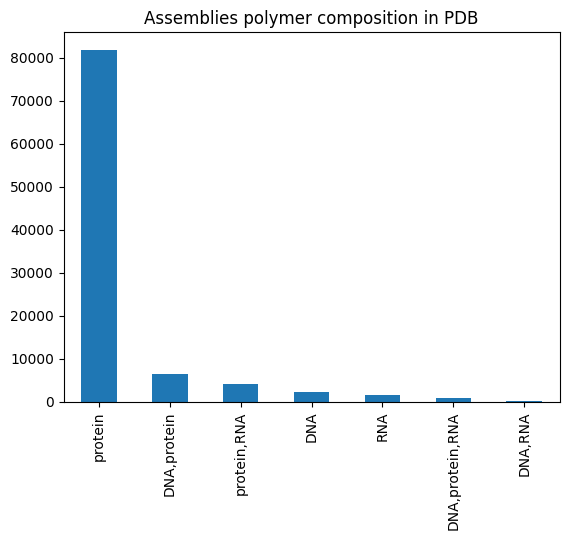

In [19]:
ax = assemblies_polymer_composition.plot(kind="bar")
ax.set_title("Assemblies polymer composition in PDB")

We can see that the vast majority of assemblies in the PDB are protein assemblies followed by DNA-protein and RNA-protein assemblies respectively.

## 1.3) Focusing on protein assemblies

Next, we will investigate some statistics of protein assemblies.

### 1.3.1) Creating protein-only assembly subset

We start by creating a data frame for protein assemblies.


In [20]:
# Create a new dataframe to represent protein assemblies
df_protein = df[df["ASSEMBLY_POLYMERS"] == "protein"].copy()
df_protein.head()

,ASSEMBLY_STRING,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING_WITH_UNP_NUMBERING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,hasChimericChains,ASSEMBLY_TYPE,EXP_METHOD,SPECIES_NAME,NUM_ASSEMBLIES,NUM_PDB,hasProteinComponent,hasRNAComponent,hasDNAComponent,ASSEMBLY_POLYMERS
0,A0A003_2,8314d71be12be24dca4d3578fa195f89,A0A003_2|1_340,PDB-CPX-100001,nan,NAD-dependent epimerase/dehydratase domain-con...,protein name from UniProt,"6kv9_1,6kvc_1","6kv9_1,6kvc_1",False,homomeric,X-ray,culture-collection:NRRL:B:12104 [[Streptomyces,2,2,True,False,False,protein
8,A0A009IHW8_1,9a194c77dd71768ccf435eaa42f112f3,A0A009IHW8_1|134_267,PDB-CPX-100009,nan,2' cyclic ADP-D-ribose synthase AbTIR,protein name from UniProt,"7uwg_1,7uwg_2,7uwg_3,7uwg_4",7uwg_2,False,monomeric,X-ray,Acinetobacter baumannii,4,1,True,False,False,protein
9,A0A009IHW8_4,5d684c3214db91581ccfba66c64602d0,A0A009IHW8_4|134_267,PDB-CPX-100010,nan,2' cyclic ADP-D-ribose synthase AbTIR,protein name from UniProt,7uxu_1,7uxu_1,False,homomeric,EM,Acinetobacter baumannii,1,1,True,False,False,protein
15,A0A010_2,85b8916f3c47a9edbc46c0ea75bbe361,A0A010_2|1_260,PDB-CPX-100016,nan,MoeN5,protein name from UniProt,"5b00_1,5b00_2,5b01_1,5b01_2,5b01_3,5b01_4,5b01_5","5b00_1,5b01_1",False,homomeric,X-ray,culture-collection:NRRL:B:12104 [[Streptomyces,7,2,True,False,False,protein
16,A0A011_2,4a9d6ab84f75bc191c0700e7ac77fb7c,A0A011_2|1_281,PDB-CPX-100017,nan,MoeO5,protein name from UniProt,"3vk5_1,3vka_1,3vkb_1,3vkc_1,3vkd_1","3vk5_1,3vka_1,3vkb_1,3vkc_1,3vkd_1",False,homomeric,X-ray,culture-collection:NRRL:B:12104 [[Streptomyces,5,5,True,False,False,protein


### 1.3.2) Assembly components mapped to UniProt accessions

Then, we check if the components in the protein assemblies are all mapped to UniProt accessions. Reasons why a protein may not be mapped to a UniProt accession include:

* Length limitation (sequence too short to map reliably)
* Type limitation (certain classes of proteins, such as antibodies, have no UniProt accessions

In [21]:
# Column to indicate whether all components in the protein assembly are mapped to UniProt
df_protein["hasAllUNPMapping"] = df_protein["ASSEMBLY_STRING"].apply(lambda x: ui.validate_uniprot(x, all))

In [22]:
# Number of protein assemblies with all components mapped to UniProt
mapped_protein_assemblies_all = df_protein[df_protein["hasAllUNPMapping"] == True]
mapped_protein_assemblies_all.head()

,ASSEMBLY_STRING,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING_WITH_UNP_NUMBERING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,hasChimericChains,ASSEMBLY_TYPE,EXP_METHOD,SPECIES_NAME,NUM_ASSEMBLIES,NUM_PDB,hasProteinComponent,hasRNAComponent,hasDNAComponent,ASSEMBLY_POLYMERS,hasAllUNPMapping
0,A0A003_2,8314d71be12be24dca4d3578fa195f89,A0A003_2|1_340,PDB-CPX-100001,nan,NAD-dependent epimerase/dehydratase domain-con...,protein name from UniProt,"6kv9_1,6kvc_1","6kv9_1,6kvc_1",False,homomeric,X-ray,culture-collection:NRRL:B:12104 [[Streptomyces,2,2,True,False,False,protein,True
8,A0A009IHW8_1,9a194c77dd71768ccf435eaa42f112f3,A0A009IHW8_1|134_267,PDB-CPX-100009,nan,2' cyclic ADP-D-ribose synthase AbTIR,protein name from UniProt,"7uwg_1,7uwg_2,7uwg_3,7uwg_4",7uwg_2,False,monomeric,X-ray,Acinetobacter baumannii,4,1,True,False,False,protein,True
9,A0A009IHW8_4,5d684c3214db91581ccfba66c64602d0,A0A009IHW8_4|134_267,PDB-CPX-100010,nan,2' cyclic ADP-D-ribose synthase AbTIR,protein name from UniProt,7uxu_1,7uxu_1,False,homomeric,EM,Acinetobacter baumannii,1,1,True,False,False,protein,True
15,A0A010_2,85b8916f3c47a9edbc46c0ea75bbe361,A0A010_2|1_260,PDB-CPX-100016,nan,MoeN5,protein name from UniProt,"5b00_1,5b00_2,5b01_1,5b01_2,5b01_3,5b01_4,5b01_5","5b00_1,5b01_1",False,homomeric,X-ray,culture-collection:NRRL:B:12104 [[Streptomyces,7,2,True,False,False,protein,True
16,A0A011_2,4a9d6ab84f75bc191c0700e7ac77fb7c,A0A011_2|1_281,PDB-CPX-100017,nan,MoeO5,protein name from UniProt,"3vk5_1,3vka_1,3vkb_1,3vkc_1,3vkd_1","3vk5_1,3vka_1,3vkb_1,3vkc_1,3vkd_1",False,homomeric,X-ray,culture-collection:NRRL:B:12104 [[Streptomyces,5,5,True,False,False,protein,True


#### 1.3.2.1) Every component mapped to UniProt accessions

In [23]:
# Calculate the percentage of protein assemblies with all components mapped to UniProt
print("Across the PDB, %i%% percent of protein assemblies have all of their components mapped to UniProt" % (len(mapped_protein_assemblies_all)/len(df_protein)*100))

Across the PDB, 78% percent of protein assemblies have all of their components mapped to UniProt


1.3.2.2) Any of the components mapped to UniProt accessions

In [24]:
# Column to indicate whether any one of the components in the protein assembly is mapped to UniProt
df_protein["hasAnyUNPMapping"] = df_protein["ASSEMBLY_STRING"].apply(lambda x: ui.validate_uniprot(x, any))

In [25]:
# Number of protein assemblies with at least one component mapped to UniProt
mapped_protein_assemblies_any = df_protein[df_protein["hasAnyUNPMapping"] == True]
mapped_protein_assemblies_any.head(10)

,ASSEMBLY_STRING,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING_WITH_UNP_NUMBERING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,hasChimericChains,...,EXP_METHOD,SPECIES_NAME,NUM_ASSEMBLIES,NUM_PDB,hasProteinComponent,hasRNAComponent,hasDNAComponent,ASSEMBLY_POLYMERS,hasAllUNPMapping,hasAnyUNPMapping
0,A0A003_2,8314d71be12be24dca4d3578fa195f89,A0A003_2|1_340,PDB-CPX-100001,nan,NAD-dependent epimerase/dehydratase domain-con...,protein name from UniProt,"6kv9_1,6kvc_1","6kv9_1,6kvc_1",False,...,X-ray,culture-collection:NRRL:B:12104 [[Streptomyces,2,2,True,False,False,protein,True,True
8,A0A009IHW8_1,9a194c77dd71768ccf435eaa42f112f3,A0A009IHW8_1|134_267,PDB-CPX-100009,nan,2' cyclic ADP-D-ribose synthase AbTIR,protein name from UniProt,"7uwg_1,7uwg_2,7uwg_3,7uwg_4",7uwg_2,False,...,X-ray,Acinetobacter baumannii,4,1,True,False,False,protein,True,True
9,A0A009IHW8_4,5d684c3214db91581ccfba66c64602d0,A0A009IHW8_4|134_267,PDB-CPX-100010,nan,2' cyclic ADP-D-ribose synthase AbTIR,protein name from UniProt,7uxu_1,7uxu_1,False,...,EM,Acinetobacter baumannii,1,1,True,False,False,protein,True,True
15,A0A010_2,85b8916f3c47a9edbc46c0ea75bbe361,A0A010_2|1_260,PDB-CPX-100016,nan,MoeN5,protein name from UniProt,"5b00_1,5b00_2,5b01_1,5b01_2,5b01_3,5b01_4,5b01_5","5b00_1,5b01_1",False,...,X-ray,culture-collection:NRRL:B:12104 [[Streptomyces,7,2,True,False,False,protein,True,True
16,A0A011_2,4a9d6ab84f75bc191c0700e7ac77fb7c,A0A011_2|1_281,PDB-CPX-100017,nan,MoeO5,protein name from UniProt,"3vk5_1,3vka_1,3vkb_1,3vkc_1,3vkd_1","3vk5_1,3vka_1,3vkb_1,3vkc_1,3vkd_1",False,...,X-ray,culture-collection:NRRL:B:12104 [[Streptomyces,5,5,True,False,False,protein,True,True
17,A0A014C6J9_2,a443abb2485d89de4e76f1747c3683c3,A0A014C6J9_2|1_130,PDB-CPX-100018,nan,Two-component system response regulator protein,protein name from UniProt,6br7_1,6br7_1,False,...,X-ray,Acinetobacter sp.,1,1,True,False,False,protein,True,True
18,A0A014M399_2,c389bc2dd3f377c1ce88c5b65b04f541,A0A014M399_2|35_203,PDB-CPX-100019,nan,DAC domain-containing protein,protein name from UniProt,"7dfx_1,7dg0_1","7dfx_1,7dg0_1",False,...,X-ray,Mycoplasma ovipneumoniae,2,2,True,False,False,protein,True,True
19,A0A016UNP9_1,a100af5d0caedc664680e517423c4ce6,A0A016UNP9_1|18_67,PDB-CPX-100020,nan,ShKT domain-containing protein,protein name from UniProt,2md0_1,2md0_1,False,...,NMR,Ancylostoma ceylanicum,1,1,True,False,False,protein,True,True
20,A0A016UZK2_3,10f3712ebdc029f8d6f28323f93865ae,A0A016UZK2_3|2330_2772,PDB-CPX-100021,nan,Integrase catalytic domain-containing protein,protein name from UniProt,7a4a_1,7a4a_1,False,...,EM,Ancylostoma ceylanicum,1,1,True,False,False,protein,True,True
21,A0A017T5A5_1,c934b4492025564967ecdd3c2c3e5dcc,A0A017T5A5_1|1_397,PDB-CPX-100022,nan,Putative cytochrome P450 hydroxylase,protein name from UniProt,6gmf_1,6gmf_1,False,...,X-ray,Chondromyces apiculatus,1,1,True,False,False,protein,True,True


In [26]:
# Calculate the percentage of protein assemblies with at least one component mapped to UniProt
print("Across the PDB archive %i%% of the protein-only assemblies have at least one component mapped to UniProt" % (len(mapped_protein_assemblies_any)/len(df_protein)*100))

Across the PDB archive 90% of the protein-only assemblies have at least one component mapped to UniProt


## 1.4) Focusing on RNA assemblies

Next, we will investigate some statistics of RNA assemblies.

### 1.4.1) Creating RNA-only assembly subset

We start by creating a data frame for RNA assemblies.

In [27]:
# Create a new dataframe to represent protein assemblies
df_rna = df[df["ASSEMBLY_POLYMERS"] == "RNA"].copy()
df_rna

,ASSEMBLY_STRING,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING_WITH_UNP_NUMBERING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,hasChimericChains,ASSEMBLY_TYPE,EXP_METHOD,SPECIES_NAME,NUM_ASSEMBLIES,NUM_PDB,hasProteinComponent,hasRNAComponent,hasDNAComponent,ASSEMBLY_POLYMERS
95820,"RF00001_1,RF02541_1",6be50c8e05704a0954f78d332ed58465,"RF00001_1|2_118,RF02541_1|1_2878",PDB-CPX-195821,nan,nan,nan,"3fwo_1,3jq4_1","3fwo_1,3jq4_1",False,heteromeric,X-ray,None,2,2,False,True,False,RNA
95821,"RF00004_1,RF00026_1",5bab3d2cb9ce093b15681b8fdb2e48b3,"RF00004_1|71_111,RF00026_1|2_73",PDB-CPX-195822,nan,nan,nan,2lkr_1,2lkr_1,False,heteromeric,NMR,None,1,1,False,True,False,RNA
95822,RF00005_1,4f0d79dcd7ced91fe051bf1e8070ab41,"RF00005_1|1_73,RF00005_1|1_72,RF00005_1|1_74,R...",PDB-CPX-195823,nan,tRNA,RNA name from Rfam,"1ehz_1,1evv_1,1fir_1,1i9v_1,1tn1_1,1tn2_1,1tra...","1ehz_1,1evv_1,1fir_1,1i9v_1,1tn1_1,1tn2_1,1tra...",False,monomeric,"EM,Hybrid,X-ray",None,32,27,False,True,False,RNA
95823,"RF00005_1,RF00005_1,RF00005_1,RNA_486d_2_1,RNA...",c91e3043a128cd509e7d876f4182848b,"RF00005_1|1_72,RF00005_1|1_72,RF00005_1|1_72,R...",PDB-CPX-195824,nan,tRNA and RNA,RNA name from Rfam with unmapped RNA,486d_1,486d_1,False,heteromeric,X-ray,None,1,1,False,True,False,RNA
95824,"RF00005_1,RF02340_1",07132dd6271cb0bd0079e34342fb06f5,"RF00005_1|1_136,RF02340_1|31_100,RF00005_1|1_1...",PDB-CPX-195825,nan,nan,nan,"7lyf_1,7lyg_1","7lyf_1,7lyg_1",False,heteromeric,X-ray,None,2,2,False,True,False,RNA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97395,RNA_8i43_1_1,1ca70e34628aabf601d2d1a5b57862e2,RNA_8i43_1_1|1_19,PDB-CPX-197396,nan,RNA,general nucleic acid name,8i43_1,8i43_1,False,monomeric,NMR,None,1,1,False,True,False,RNA
97396,RNA_8i44_1_1,ff93bc57df8b10ef7567ec512959c7ab,RNA_8i44_1_1|1_19,PDB-CPX-197397,nan,RNA,general nucleic acid name,8i44_1,8i44_1,False,monomeric,NMR,None,1,1,False,True,False,RNA
97397,RNA_8i45_1_1,02685e964f88f99c12601cc9bc803ecf,RNA_8i45_1_1|1_19,PDB-CPX-197398,nan,RNA,general nucleic acid name,8i45_1,8i45_1,False,monomeric,NMR,None,1,1,False,True,False,RNA
97398,RNA_8i46_1_1,2260a56183b62a1ecdece79a4302a21e,RNA_8i46_1_1|1_19,PDB-CPX-197399,nan,RNA,general nucleic acid name,8i46_1,8i46_1,False,monomeric,NMR,None,1,1,False,True,False,RNA


### 1.3.2) Assembly components mapped to Rfam accessions
Then, we check if the components in the RNA assemblies are all mapped to Rfam accessions. Reasons why an RNA may not be mapped to a Rfam accession include:

Length limitation (sequence too short to map reliably)
Type limitation (certain types, such as mRNAs, have no Rfam accessions

In [28]:
# Column to indicate whether all components in the RNA assembly are mapped to Rfam
df_rna["hasAllRfamMapping"] = df_rna["ASSEMBLY_STRING"].apply(lambda x: ui.validate_rfam(x, all))

In [29]:
# Number of rna assemblies with all components mapped to Rfam
mapped_rna_assemblies_all = df_rna[df_rna["hasAllRfamMapping"] == True]
mapped_rna_assemblies_all.shape[0]

85

## 2) Variation of stoichiometry in assemblies in the PDB

Structures in the PDB archive are determined to investigate a specific scientific problem. Consequently, a PDB structure does not always represent the biological complex. For example, PDB entry [1abw](https://www.ebi.ac.uk/pdbe/entry/pdb/1abw) contains a human haemoglobin trimer where two copies of the alpha subunit are linked together. This trimer represents a deviation from the biological heterotetrameric state of haemoglobin. In this section of the notebook, we analyse UniProt accessions in which the assemblies exist with different stoichiometries.

In [30]:
# Create a dataframe to represent monomeric protein assemblies
df_protein_monomeric = df_protein[df_protein["ASSEMBLY_TYPE"] == "monomeric"]
# Create a dataframe to represent homomeric protein assemblies
df_protein_homomeric = df_protein[df_protein["ASSEMBLY_TYPE"] == "homomeric"]
# Create a dataframe to represent heteromeric protein assemblies
df_protein_heteromeric = df_protein[df_protein["ASSEMBLY_TYPE"] == "heteromeric"]

# Calculate the percentage of monomeric protein assemblies
percentage_monomeric_assemblies = (len(df_protein_monomeric)/len(df_protein))*100
# Calculate the percentage of homomeric protein assemblies
percentage_homomeric_assemblies = (len(df_protein_homomeric)/len(df_protein))*100
# Calculate the percentage of heteromeric protein assemblies
percentage_heteromeric_assemblies = (len(df_protein_heteromeric)/len(df_protein))*100

In [31]:
print("Out of all the assemblies in the PDB, %i%% are monomeric, %i%% are homomeric and %i%% are heteromeric." % (
    percentage_monomeric_assemblies,
    percentage_homomeric_assemblies,
    percentage_heteromeric_assemblies
))

Out of all the assemblies in the PDB, 31% are monomeric, 36% are homomeric and 31% are heteromeric.


### 2.1) Homomeric protein assemblies

Next, we will investigate the homomeric protein assemblies.

In [32]:
# Create a dataframe to represent homomeric protein assemblies with all components mapped to UniProt
df_protein_homomeric_mapped = df_protein_homomeric[(df_protein_homomeric["hasAllUNPMapping"] == True)]
df_protein_homomeric_mapped

,ASSEMBLY_STRING,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING_WITH_UNP_NUMBERING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,hasChimericChains,...,EXP_METHOD,SPECIES_NAME,NUM_ASSEMBLIES,NUM_PDB,hasProteinComponent,hasRNAComponent,hasDNAComponent,ASSEMBLY_POLYMERS,hasAllUNPMapping,hasAnyUNPMapping
0,A0A003_2,8314d71be12be24dca4d3578fa195f89,A0A003_2|1_340,PDB-CPX-100001,nan,NAD-dependent epimerase/dehydratase domain-con...,protein name from UniProt,"6kv9_1,6kvc_1","6kv9_1,6kvc_1",False,...,X-ray,culture-collection:NRRL:B:12104 [[Streptomyces,2,2,True,False,False,protein,True,True
9,A0A009IHW8_4,5d684c3214db91581ccfba66c64602d0,A0A009IHW8_4|134_267,PDB-CPX-100010,nan,2' cyclic ADP-D-ribose synthase AbTIR,protein name from UniProt,7uxu_1,7uxu_1,False,...,EM,Acinetobacter baumannii,1,1,True,False,False,protein,True,True
15,A0A010_2,85b8916f3c47a9edbc46c0ea75bbe361,A0A010_2|1_260,PDB-CPX-100016,nan,MoeN5,protein name from UniProt,"5b00_1,5b00_2,5b01_1,5b01_2,5b01_3,5b01_4,5b01_5","5b00_1,5b01_1",False,...,X-ray,culture-collection:NRRL:B:12104 [[Streptomyces,7,2,True,False,False,protein,True,True
16,A0A011_2,4a9d6ab84f75bc191c0700e7ac77fb7c,A0A011_2|1_281,PDB-CPX-100017,nan,MoeO5,protein name from UniProt,"3vk5_1,3vka_1,3vkb_1,3vkc_1,3vkd_1","3vk5_1,3vka_1,3vkb_1,3vkc_1,3vkd_1",False,...,X-ray,culture-collection:NRRL:B:12104 [[Streptomyces,5,5,True,False,False,protein,True,True
17,A0A014C6J9_2,a443abb2485d89de4e76f1747c3683c3,A0A014C6J9_2|1_130,PDB-CPX-100018,nan,Two-component system response regulator protein,protein name from UniProt,6br7_1,6br7_1,False,...,X-ray,Acinetobacter sp.,1,1,True,False,False,protein,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97877,X5KA67_2,492c4015b0321a5a5d3246bf247562c2,X5KA67_2|1_482,PDB-CPX-197878,nan,Asparagine--tRNA ligase,protein name from UniProt,"6pqh_1,6pqh_2",6pqh_1,False,...,X-ray,DSM 15670,2,1,True,False,False,protein,True,True
97879,X5KVH4_3,9e052c9a63210cf688fcbc9a59955013,X5KVH4_3|1_208,PDB-CPX-197880,nan,Type B chloramphenicol O-acetyltransferase,protein name from UniProt,6mfk_2,6mfk_2,False,...,X-ray,DSM 15670,1,1,True,False,False,protein,True,True
97880,X5MEI1_8,ac23653f4d0ae5b66ba7cad8159adfa5,X5MEI1_8|1_206,PDB-CPX-197881,nan,3'-5' exonuclease domain-containing protein,protein name from UniProt,"7mpo_1,7mpp_1","7mpo_1,7mpp_1",False,...,X-ray,DSM 28221,2,2,True,False,False,protein,True,True
97881,X7XQY2_4,11cc7dd7f3358c7d60b38bd529c9c2c7,X7XQY2_4|1_269,PDB-CPX-197882,nan,Enoyl-[acyl-carrier-protein] reductase [NADH],protein name from UniProt,7kxa_1,7kxa_1,False,...,X-ray,Mycobacterium kansasii,1,1,True,False,False,protein,True,True


Show the top 10 species of the homomeric assemblies

In [33]:
homomeric_species_count = df_protein_homomeric_mapped["SPECIES_NAME"].value_counts().head(10)
homomeric_species_count

Humo sapiens                  3326
Escherichia coli              1301
transgenic mice                635
Mycobacterium tuberculosis     535
Pseudomonas aeruginosa         533
Saccharomyces cerevisiae       482
Bacillus subtilis              449
Thermus thermophilus           405
Arabis thaliana                366
Staphylococcus aureus          314
Name: SPECIES_NAME, dtype: int64

Text(0.5, 1.0, 'Top 10 species from which homomeric assemblies are solved')

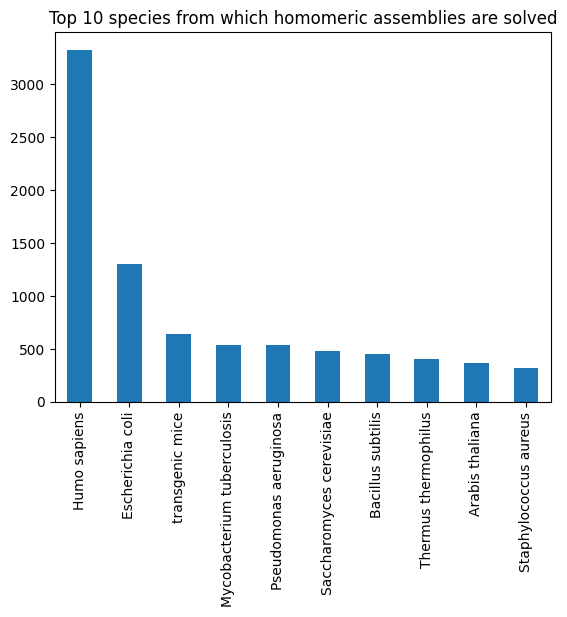

In [34]:
hx = homomeric_species_count.plot(kind="bar")
hx.set_title("Top 10 species from which homomeric assemblies are solved")

In [35]:
# Calculate the percentage of homomeric protein assemblies that have all components mapped to UniProt
percentage_homomeric_assemblies_mapped = (len(df_protein_homomeric_mapped)/len(df_protein_homomeric))*100

In [36]:
print("%i%% of the homomeric protein assemblies have all their components mapped to UniProt accession." % percentage_homomeric_assemblies_mapped)

91% of the homomeric protein assemblies have all their components mapped to UniProt accession.


We then create a list of assembly composition strings, and group them by UniProt accessions.

In [37]:
# Create a list of UniProt accessions with stoichiometry in the homomeric assemblies
homomeric_assembly_strings = df_protein_homomeric_mapped["ASSEMBLY_STRING"].tolist()

In [38]:
# Group the UniProt accessions in homomeric assemblies
homomeric_grouped_UNP_accessions = ui.group_UniProt_accessions(homomeric_assembly_strings)
print ("There are %i groups." % len(homomeric_grouped_UNP_accessions))

There are 23562 groups.


Next, we keep only those groups that has more than one assembly states.

In [39]:
# Only keep UniProt accessions that display 2 or more stoichiometry number
homomeric_UNP_accessions_with_muliple_stoic = {k: sorted([int(x) for x in grp]) for k, grp in homomeric_grouped_UNP_accessions.items() if len(grp) > 1}
# Number of UniProt accessions with multiple stoichiometry numbers
homomeric_UNP_accession_stoic_count = len(homomeric_UNP_accessions_with_muliple_stoic)

In [40]:
print("There are %i UniProt accessions that exist in different stoichiometries in homomeric assemblies" % homomeric_UNP_accession_stoic_count)

There are 2955 UniProt accessions that exist in different stoichiometries in homomeric assemblies


In [41]:
# Count the stoichiometry number for UniProt accessions with two or more stoichiometries
homomeric_UNP_accessions_with_multiple_stoic_count = [(k, len(grp)) for k, grp in homomeric_UNP_accessions_with_muliple_stoic.items()]

In [42]:
# Sort the count of stoichiometry number in descending order
sorted_homomeric_UNP_accessions_with_multiple_stoic_count = sorted(homomeric_UNP_accessions_with_multiple_stoic_count, key=lambda x: x[1], reverse=True)

In [43]:
# Show the top 10 UniProt accessions with highest stoichiometry number count
sorted_homomeric_UNP_accessions_with_multiple_stoic_count[:12]

[('P05067', 12),
 ('P10636', 10),
 ('P68135', 10),
 ('P10997', 9),
 ('P37840', 8),
 ('B2J6D9', 7),
 ('P02766', 7),
 ('P03354', 7),
 ('P04156', 7),
 ('P12493', 7),
 ('P41784', 7),
 ('Q13148', 7)]

### 2.2) Heteromeric protein assemblies

Now, we will investigate the heteromeric protein assemblies.

In [44]:
# Create a dataframe to represent heteromeric protein assemblies with all components mapped to UniProt
df_protein_heteromeric_mapped = df_protein_heteromeric[(df_protein_heteromeric["hasAllUNPMapping"] == True)]
df_protein_heteromeric_mapped.head()

,ASSEMBLY_STRING,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING_WITH_UNP_NUMBERING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,hasChimericChains,...,EXP_METHOD,SPECIES_NAME,NUM_ASSEMBLIES,NUM_PDB,hasProteinComponent,hasRNAComponent,hasDNAComponent,ASSEMBLY_POLYMERS,hasAllUNPMapping,hasAnyUNPMapping
24,"A0A022MRT4_1,A0A022MRT4_1",f4c44eb7a88d77df2d16592a433f4da4,"A0A022MRT4_1|1_436,A0A022MRT4_1|1_436",PDB-CPX-100025,nan,AMP-dependent synthetase/ligase domain-contain...,protein name from UniProt,"6siw_1,6tm4_1","6siw_1,6tm4_1",False,...,X-ray,Streptomyces sp.,2,2,True,False,False,protein,True,True
28,"A0A023FDY8_1,P13500_1",b181cacca3c24b39d0b36f18bf2df31a,"A0A023FDY8_1|30_114,P13500_1|24_99",PDB-CPX-100029,nan,C-C motif chemokine 2 and Evasin P974,heterodimer,7so0_1,7so0_1,False,...,X-ray,Cayenne tick,1,1,True,False,False,protein,True,True
30,"A0A023FDY8_1,P80098_1",6fecbfd42b482420704db030e5d1342f,"A0A023FDY8_1|30_114,P80098_1|24_99",PDB-CPX-100031,nan,C-C motif chemokine 7 and Evasin P974,heterodimer,"7s58_1,7s58_2,7s58_3,7s58_4",7s58_1,False,...,X-ray,Cayenne tick,4,1,True,False,False,protein,True,True
31,"A0A023FDY8_1,Q92583_1",7fe71deb6c055484a5bddd7c8876e922,"A0A023FDY8_1|30_114,Q92583_1|24_94",PDB-CPX-100032,nan,Evasin P974 and C-C motif chemokine 17,heterodimer,"7s4n_1,7s4n_2",7s4n_1,False,...,X-ray,Cayenne tick,2,1,True,False,False,protein,True,True
57,"A0A023X3C8_1,A0A023X3Z4_2",5166d7eac1c7a57a1b74d77b12efb0a2,"A0A023X3C8_1|1_273,A0A023X3Z4_2|1_118",PDB-CPX-100058,nan,RR RsiG and RNA polymerase sigma-70 domain-con...,heterodimer,7lq4_1,7lq4_1,False,...,X-ray,strain P-1,1,1,True,False,False,protein,True,True


In [45]:
# Calculate the percentage of heteromeric protein assemblies that have all components mapped to UniProt
percentage_heteromeric_assemblies_mapped = (len(df_protein_heteromeric_mapped)/len(df_protein_heteromeric))*100

In [46]:
print("%i%% of the heteromeric protein assemblies have all their components mapped to UniProt accession." % percentage_heteromeric_assemblies_mapped)

52% of the heteromeric protein assemblies have all their components mapped to UniProt accession.


In [47]:
# Create a list of UniProt accessions with stoichiometry in the heteromeric assemblies
heteromeric_assembly_strings = df_protein_heteromeric_mapped["ASSEMBLY_STRING"].tolist()
heteromeric_assembly_components = [assembly.split(",") for assembly in heteromeric_assembly_strings]
heteromeric_assembly_components = [item for sublist in heteromeric_assembly_components for item in sublist] 
heteromeric_assembly_components = list(set(heteromeric_assembly_components))

In [48]:
# Group the UniProt accessions in the heteromeric assemblies
heteromeric_grouped_UNP_accessions = ui.group_UniProt_accessions(heteromeric_assembly_components)
print ("There are %i groups." % len(heteromeric_grouped_UNP_accessions))

There are 16318 groups.


Next, we keep only those groups with more than one assembly states.

In [49]:
# Only keep UniProt accessions that display 2 or more stoichiometry number
heteromeric_UNP_accessions_with_muliple_stoic = {k: sorted([int(x) for x in grp]) for k, grp in heteromeric_grouped_UNP_accessions.items() if len(grp) > 1}
# Number of UniProt accessions with multiple stoichiometry numbers
heteromeric_UNP_accession_stoic_count = len(heteromeric_UNP_accessions_with_muliple_stoic)

In [50]:
print("There are %i UniProt accessions that exist in different stoichiometries in heteromeric assemblies" % heteromeric_UNP_accession_stoic_count)

There are 3577 UniProt accessions that exist in different stoichiometries in heteromeric assemblies


In [51]:
# Count the stoichiometry number for UniProt accessions with two or more stoichiometries
heteromeric_UNP_accessions_with_multiple_stoic_count = [(k, len(grp)) for k, grp in heteromeric_UNP_accessions_with_muliple_stoic.items()]

In [52]:
# Sort the count of stoichiometry number in descending order
sorted_heteromeric_UNP_accessions_with_multiple_stoic_count = sorted(heteromeric_UNP_accessions_with_multiple_stoic_count, key=lambda x: x[1], reverse=True)

In [53]:
# Show the top 10 UniProt accessions with highest stoichiometry number count
sorted_heteromeric_UNP_accessions_with_multiple_stoic_count[:12]

[('P02554', 14),
 ('P68135', 13),
 ('Q2XVP4', 12),
 ('P54274', 8),
 ('Q96CW5', 8),
 ('P0CG48', 7),
 ('Q08AG7', 7),
 ('Q3J1A4', 7),
 ('P41352', 6),
 ('C8XPB6', 6),
 ('P41351', 6),
 ('P23258', 6)]

We now compare the UniProt accessions that are used by homomeric and heteromeric assemblies

In [54]:
added, removed, modified, same = ui.dict_compare(homomeric_UNP_accessions_with_muliple_stoic, heteromeric_UNP_accessions_with_muliple_stoic)

In [55]:
print("There are %i UniProt accessions unique for homomeric assemblies" % len(added))

There are 2653 UniProt accessions unique for homomeric assemblies


In [56]:
print("There are %i UniProt accessions unique for heteromeric assemblies" % len(removed))

There are 3275 UniProt accessions unique for heteromeric assemblies


In [57]:
print("There are %i UniProt accessions that are common to both homomeric and heteromeric assemblies with the same assembly states" % len(same))

There are 15 UniProt accessions that are common to both homomeric and heteromeric assemblies with the same assembly states


In [58]:
print("There are %i UniProt accessions that are common to both homomeric and heteromeric assemblies with varying assembly states" % len(modified))

There are 287 UniProt accessions that are common to both homomeric and heteromeric assemblies with varying assembly states


## 3) Sub-assembly analysis

A biological assembly can consist of multiple components where each component can have varying stoichiometry. This is best illustrated by the ribosome which is the molecular machine responsible for protein synthesis in every living cell. The ribosome is made up of two ribosomal subunits (small and large ribosomal subunits) and can bind multiple tRNAs (1-3 tRNAs), mRNA, and diverse protein factors. The binding of tRNAs and the various protein factors can induce the ribosome to undergo large-scale conformational changes which affects how the ribosome functions. As such, the ability to identify the sub- and super-assemblies of a biological assembly is key in identifying the contribution of each component to the function of the whole assembly and the relationships that exist between the components.

We define sub- and super-assembly using the composition and stoichiometry data. We defined a sub-assembly as an assembly where all components map to UniProt accessions and where these components are also present in another assembly. For example, PDB entry [5jdo](https://pdbe.org/5jdo) contains haemoglobin (UniProt [P68871](https://pdbe-kb.org/proteins/P68871) and UniProt [P69905](https://pdbe-kb.org/proteins/P69905)) bound to the haptoglobin-haemoglobin receptor (UniProt [G0UVW6](https://pdbe-kb.org/proteins/G0UVW6)). A sub-assembly of this assembly is haemoglobin. We defined a super-assembly as an assembly that has all the same elements of another assembly plus additional members. Again, all members must map to a UniProt accession. In the example above,  PDB entry [5jdo](https://pdbe.org/5jdo is a super-assembly of haemoglobin.

### 3.1) Reading in the data

In [59]:
df_subassemblies = pd.read_csv("data/subassemblies_data.csv")
df_subassemblies.head()

,SUBASSEMBLY_ID,SUPERASSEMBLY_ID
0,PDB-CPX-100052,PDB-CPX-100053
1,PDB-CPX-100062,PDB-CPX-100063
2,PDB-CPX-100062,PDB-CPX-100064
3,PDB-CPX-100062,PDB-CPX-100065
4,PDB-CPX-100062,PDB-CPX-100066


In [60]:
print("There are %i unique sub-assemblies, and %i unique super-assemblies in the PDB." % (
    df_subassemblies["SUBASSEMBLY_ID"].nunique(),
    df_subassemblies["SUPERASSEMBLY_ID"].nunique()
))

There are 5099 unique sub-assemblies, and 14279 unique super-assemblies in the PDB.


### 3.2) Matching sub- and super-assemblies

We can match sub- and super-assemblies.

In [61]:
subassembly_list = df_subassemblies["SUBASSEMBLY_ID"].tolist()
superassembly_list = df_subassemblies["SUPERASSEMBLY_ID"].tolist()
subassembly_pairs = list(zip(subassembly_list, superassembly_list))

In [62]:
subassembly_pairs[:10]

[('PDB-CPX-100052', 'PDB-CPX-100053'),
 ('PDB-CPX-100062', 'PDB-CPX-100063'),
 ('PDB-CPX-100062', 'PDB-CPX-100064'),
 ('PDB-CPX-100062', 'PDB-CPX-100065'),
 ('PDB-CPX-100062', 'PDB-CPX-100066'),
 ('PDB-CPX-100068', 'PDB-CPX-100069'),
 ('PDB-CPX-100068', 'PDB-CPX-100070'),
 ('PDB-CPX-100068', 'PDB-CPX-100071'),
 ('PDB-CPX-100068', 'PDB-CPX-100072'),
 ('PDB-CPX-100068', 'PDB-CPX-100073')]

In [63]:
grouped_subassemblies, grouped_superassemblies = ui.group_subassemblies(subassembly_pairs)

In [64]:
# Assemblies having at least two super-assemblies
assemblies_with_muliple_superassembly = {k: grp for k, grp in grouped_subassemblies.items() if len(grp) > 1}
print("Only %i assemblies have 2 or more super-assemblies" % len(assemblies_with_muliple_superassembly))

Only 2118 assemblies have 2 or more super-assemblies


In [65]:
# Assemblies having at least two super-assemblies
assemblies_with_muliple_subassembly = {k: grp for k, grp in grouped_superassemblies.items() if len(grp) > 1}
print("Only %i assemblies have 2 or more sub-assemblies" % len(assemblies_with_muliple_subassembly))

Only 3026 assemblies have 2 or more sub-assemblies


### 3.3) Finding the assemblies in the PDB which have the highest number of super-assemblies

In [66]:
# Count the number of superassemblies
superassemblies_count = [(k, len(grp)) for k, grp in assemblies_with_muliple_superassembly.items()]

# Sort the count of superassemblies in descending order
sorted_superassemblies_count = sorted(superassemblies_count, key=lambda x: x[1], reverse=True)

# Show the top 10 entries with the highest number of superassemblies
sorted_superassemblies_count[:10]

# Get the PDB Complex ID for the top 10 entries
top_ten_entries_ids = [x[0] for x in sorted_superassemblies_count[:10]]

top_ten_entries_ids

# Show the assemblies data for the top 10 entries
df[df["PDB_COMPLEX_ID"].isin(top_ten_entries_ids)]

,ASSEMBLY_STRING,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING_WITH_UNP_NUMBERING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,hasChimericChains,ASSEMBLY_TYPE,EXP_METHOD,SPECIES_NAME,NUM_ASSEMBLIES,NUM_PDB,hasProteinComponent,hasRNAComponent,hasDNAComponent,ASSEMBLY_POLYMERS
33053,P00734_1,34994857885a86309e94ceddaa3a29d1,"P00734_1|328_622,P00734_1|334_620,P00734_1|199...",PDB-CPX-133054,nan,Thrombin light chain,protein name from UniProt,"1jwt_1,1mh0_1,1mh0_2,3nxp_1,3sqe_1,3sqh_1,4h6t...","1jwt_1,1mh0_1,3nxp_1,3sqe_1,3sqh_1,4h6t_1,4hzh...",False,monomeric,"NMR,X-ray",Humo sapiens,21,17,True,False,False,protein
34972,P01887_1,6783d9c622188cd1f0d5999328f1dc25,P01887_1|21_119,PDB-CPX-134973,nan,Beta-2-microglobulin,protein name from UniProt,6i8c_1,6i8c_1,False,monomeric,X-ray,transgenic mice,1,1,True,False,False,protein
35127,P01889_1,f995aab5c7ba80cd979ddf176f67f392,P01889_1|25_298,PDB-CPX-135128,nan,"HLA class I histocompatibility antigen, B alph...",protein name from UniProt,"4lcy_1,4lcy_2,4lcy_3,4lcy_4,4lcy_5,4lcy_6",,False,monomeric,X-ray,Humo sapiens,6,1,True,False,False,protein
35168,"P01889_1,P61769_1",9b041b9a12854cee096265898b9728cf,"P01889_1|25_300,P61769_1|21_119",PDB-CPX-135169,nan,Major Histocompatibility Complex,PDBe curated,4qrp_3,,False,heteromeric,X-ray,Humo sapiens,1,1,True,False,False,protein
37701,"P04439_1,P61769_1",550ca8ff8255ffafd03c46e8acd42e04,"P04439_1|25_294,P61769_1|21_117,P04439_1|25_29...",PDB-CPX-137702,nan,"HLA class I histocompatibility antigen, A alph...",heterodimer,"1hla_1,2hla_1,3hla_1,6q3s_2,6rp9_3","1hla_1,2hla_1,3hla_1",False,heteromeric,X-ray,Humo sapiens,5,5,True,False,False,protein
44159,P0DTC2_1,0d27ac006c0a8209ecd46ccb1b6700aa,"P0DTC2_1|1_311,P0DTC2_1|1_1273,P0DTC2_1|816_85...",PDB-CPX-144160,nan,Spike protein S2',protein name from UniProt,"7b62_1,7fg7_1,7my8_1,7p5g_1,7p5q_1,7p5s_1,7r95...","7b62_1,7fg7_1,7my8_1,7p5g_1,7p5q_1,7p5s_1,7r95...",False,monomeric,"EM,NMR,X-ray",Wuhan seafood,11,11,True,False,False,protein
44160,"P0DTC2_1,P0DTC2_1",eb6f6fc338504d1a2f77479219c8a741,"P0DTC2_1|1168_1203,P0DTC2_1|917_1204,P0DTC2_1|...",PDB-CPX-144161,nan,Spike protein S2',protein name from UniProt,"7y9n_1,7zr2_1","7y9n_1,7zr2_1",False,heteromeric,X-ray,Wuhan seafood,2,2,True,False,False,protein
44649,P0DTC2_3,fce021a7226db7e75608d3277a4537d5,"P0DTC2_3|910_988:994_1009:1010_1036,P0DTC2_3|9...",PDB-CPX-144650,CPX-7043,SARS-CoV-2 post-fusion S2 Spike complex,complex portal,"6lxt_1,6lxt_2,6m1v_1,6vsb_1,6vxx_1,6vyb_1,6x29...","6lxt_1,6m1v_1,6vsb_1,6vxx_1,6vyb_1,6x29_1,6x2a...",False,homomeric,"EM,NMR,X-ray",Wuhan seafood,284,280,True,False,False,protein
44650,"P0DTC2_3,P0DTC2_3",7c5ec2db93427b0b0c00a752bb808076,"P0DTC2_3|1175_1211,P0DTC2_3|906_957",PDB-CPX-144651,CPX-5682,SARS-CoV-2 cleaved Spike protein complex,complex portal,7ek6_1,7ek6_1,False,heteromeric,X-ray,Wuhan seafood,1,1,True,False,False,protein
47907,P17291_1,6b34f4b63ff47e3ee5ed732d97784be6,P17291_1|7_156,PDB-CPX-147908,nan,30S ribosomal protein S7,protein name from UniProt,1rss_1,1rss_1,False,monomeric,X-ray,Thermus thermophilus,1,1,True,False,False,protein


# 4) Naming of Assemblies

Providing a good name for a complex in the PDB poses a significant challenge. Complexes with a singular component can get the name of this component, regardless of the stoichiometry of the component. Examples of this would be Lysozyme, Insulin or Ferritin. In assemblies where the singular component is either DNA or RNA, and no mapping to external resources is present, the name is given as DNA or RNA, respectively. In the case of proteins, we can use the protein name the depositor provided if no external mapping is available. If the component maps to a UniProt accession, then we can use the protein name from UniProt. This approach allows us to automatically name some of the multi-component assemblies, including proteins bound to nucleic acids.


In [67]:
pdb_complexes = df[df["ASSEMBLY_TYPE"] != "monomeric"]
pdb_complexes

,ASSEMBLY_STRING,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING_WITH_UNP_NUMBERING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,hasChimericChains,ASSEMBLY_TYPE,EXP_METHOD,SPECIES_NAME,NUM_ASSEMBLIES,NUM_PDB,hasProteinComponent,hasRNAComponent,hasDNAComponent,ASSEMBLY_POLYMERS
0,A0A003_2,8314d71be12be24dca4d3578fa195f89,A0A003_2|1_340,PDB-CPX-100001,nan,NAD-dependent epimerase/dehydratase domain-con...,protein name from UniProt,"6kv9_1,6kvc_1","6kv9_1,6kvc_1",False,homomeric,X-ray,culture-collection:NRRL:B:12104 [[Streptomyces,2,2,True,False,False,protein
1,"A0A009I821_1,A0A009L7S8_1,A0A014CLK2_1,A0A1V3D...",e063e8ace0bd49972940e0b8bd74783f,"A0A009I821_1|1_109,A0A009L7S8_1|1_103,A0A014CL...",PDB-CPX-100002,nan,70S ribosome and RNA,ribosome (non-Rfam),7m4w_1,7m4w_1,False,heteromeric,EM,Acinetobacter baumannii,1,1,True,True,False,"protein,RNA"
2,"A0A009I821_1,A0A009L7S8_1,A0A022IPE7_1,A0A0Q7F...",e5f5ec1896d2d626e0a23b79be0155d3,"A0A009I821_1|1_109,A0A009L7S8_1|1_103,A0A022IP...",PDB-CPX-100003,nan,70S ribosome and RNA,ribosome (non-Rfam),7ryf_1,7ryf_1,False,heteromeric,EM,Acinetobacter baumannii,1,1,True,True,False,"protein,RNA"
3,"A0A009I821_1,A0A009L7S8_1,A0A022IPE7_1,A0A0Q7F...",97679ef196cb670e86997624a5269abb,"A0A009I821_1|1_109,A0A009L7S8_1|1_103,A0A022IP...",PDB-CPX-100004,nan,70S ribosome and RNA,ribosome (non-Rfam),7ryg_1,7ryg_1,False,heteromeric,EM,Acinetobacter baumannii,1,1,True,True,False,"protein,RNA"
4,"A0A009I821_1,A0A009L7S8_1,A0A022IPE7_1,A0A0Q7F...",fa5a8f7112bc645a52e60352acb41170,"A0A009I821_1|1_109,A0A009L7S8_1|1_103,A0A022IP...",PDB-CPX-100005,nan,70S ribosome and RNA,ribosome (non-Rfam),7ryh_1,7ryh_1,False,heteromeric,EM,Acinetobacter baumannii,1,1,True,True,False,"protein,RNA"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99433,"antibody_8ek6_1_1,antibody_8ek6_2_1",80f27bdf7ddaa60835f8f0968208d528,"antibody_8ek6_1_1|1_240,antibody_8ek6_2_1|1_214",PDB-CPX-199434,nan,IG-heavy chain and IG-light lambda chain,all_antibodies,8ek6_1,8ek6_1,False,heteromeric,X-ray,None,1,1,True,False,False,protein
99434,"antibody_8ekh_1_1,antibody_8ekh_2_1",5224dc0a715c4b43daf893919a926cc8,"antibody_8ekh_1_1|1_240,antibody_8ekh_2_1|1_214",PDB-CPX-199435,nan,IG-heavy chain and IG-light lambda chain,all_antibodies,8ekh_1,8ekh_1,False,heteromeric,X-ray,None,1,1,True,False,False,protein
99436,"antibody_8fab_1_1,antibody_8fab_2_1",a1b7fcd233f14686de97ae4b60deba88,"antibody_8fab_1_1|1_212,antibody_8fab_2_1|1_224",PDB-CPX-199437,nan,IG-heavy chain and IG-light lambda chain,all_antibodies,"8fab_1,8fab_2",8fab_1,False,heteromeric,X-ray,None,2,1,True,False,False,protein
99437,"antibody_8gop_1_1,antibody_8gop_2_1",49518a8254eaade330a85c41e94b1462,"antibody_8gop_1_1|1_246,antibody_8gop_2_1|1_207",PDB-CPX-199438,nan,IG-light delta chain and TR-beta light chain,all_antibodies,8gop_1,8gop_1,False,heteromeric,X-ray,None,1,1,True,False,False,protein


## 4.1) Count the number of assemblies that have a name


In [68]:
sum_named_assemblies = (df['ASSEMBLY_NAME'] != 'nan').sum()
percentage_named_assemblies = sum_named_assemblies/df.shape[0]*100

In [69]:
print("Sum of assemblies with name: {}".format(sum_named_assemblies))

Sum of assemblies with name: 90999


In [70]:
print("Percentage of assemblies with name: {:.1f}%".format(percentage_named_assemblies))

Percentage of assemblies with name: 93.3%


## 4.2) Count the number of names generated from each naming category

In [71]:
df["NAME_SOURCE"].value_counts()

protein name from UniProt                             52634
heterodimer                                            8206
nan                                                    6529
all_unmapped_proteins_without_antibodies               5542
protein name from UniProt and DNA                      5275
general nucleic acid name                              3893
protein name from UniProt and antibody                 3396
protein name from UniProt and peptide                  3106
protein name from UniProt and RNA                      1666
complex portal                                         1648
all_antibodies                                         1555
ribosome (non-Rfam)                                    1151
common name from entity names                           893
ribosome (Rfam)                                         431
Gene Ontology                                           400
complex portal and protein                              371
complex portal super-complex            

We can see that majority of the names are derived from UniProt

## 4.3) Count the total number of names derived from UniProt

### 4.31) Breakdown the number of names derived from each UniProt category

In [72]:
up = df[df["NAME_SOURCE"].str.contains("UniProt", na=False)]
print(up.groupby("NAME_SOURCE").size().sort_values(ascending=False))

NAME_SOURCE
protein name from UniProt                             52634
protein name from UniProt and DNA                      5275
protein name from UniProt and antibody                 3396
protein name from UniProt and peptide                  3106
protein name from UniProt and RNA                      1666
protein name from UniProt and antibody and peptide       33
dtype: int64


In [73]:
# Num of unique assemblies 
up.shape[0]

66110

### 4.32) Count the number of PDB entries that have names derived from UniProt

In [74]:
df.loc[df["NAME_SOURCE"].str.contains("UniProt", na=False), 'NUM_PDB'].sum()

166096

## 4.4) Count the total number of names derived from Complex Portal

In [75]:
# Num of unique assemblies 
df["NAME_SOURCE"].str.contains("complex portal").sum()

2457

### 4.41) Breakdown the number of names derived from each Complex Portal category

In [76]:
assemblies_with_ComplexPortal_names = df[df["NAME_SOURCE"].str.contains("complex portal", na=False)]
print(assemblies_with_ComplexPortal_names.groupby("NAME_SOURCE").size().sort_values(ascending=False))

NAME_SOURCE
complex portal                  1648
complex portal and protein       371
complex portal super-complex     344
complex portal and DNA            67
multi complex portal complex      14
complex portal and RNA            13
dtype: int64


### 4.42) Count the number of PDB entries that have names derived from Complex Portal

In [77]:
df.loc[df["NAME_SOURCE"].str.contains("complex portal", na=False), 'NUM_PDB'].sum()

6746

## 4.5) Count the number of unique assemblies & PDB entries that are named as heterodimer

In [78]:
condition = df["NAME_SOURCE"] == "heterodimer"
hd = df[condition]
# Num of unique assemblies
hd.shape[0]

8206

In [79]:
# Num of PDB entries
df.loc[condition, 'NUM_PDB'].sum()

13749

## 4.6) Count the number of unique assemblies & PDB entries that are named as ribosomes

In [117]:
condition = df["NAME_SOURCE"].str.contains("ribosome")
ribosome = df[condition]
# Num of unique assemblies
ribosome.shape[0]

1582

In [118]:
# Num of PDB entries
df.loc[condition, 'NUM_PDB'].sum()

1608

## 4.7) Count the number of unique assemblies & PDB entries that have names derived from Gene Ontology

In [82]:
condition = df["NAME_SOURCE"] == "Gene Ontology"
go = df[condition]
# Num of unique assemblies
go.shape[0]

400

In [83]:
# Num of PDB entries
df.loc[condition, 'NUM_PDB'].sum()

858

In [84]:
go["ASSEMBLY_NAME"].value_counts()

Nucleosome, Histone and DNA     160
Proteasome complex              132
Photosystem II                   32
Photosystem I                    27
Hemoglobin complex               14
Nucleosome, Histone              13
Myosin complex                    9
ATP synthase, complex V           8
Respiratory chain complex IV      3
Proteasome core complex           2
Name: ASSEMBLY_NAME, dtype: int64

## 4.8) Count the number of unique assemblies & PDB entries that have manually curated names

In [85]:
condition = df["NAME_SOURCE"] == "PDBe curated"
mc = df[condition]
# Num of unique assemblies
mc.shape[0]

259

In [86]:
# Num of PDB entries
df.loc[condition, 'NUM_PDB'].sum()

616

## 4.9) Count the number of unique assemblies & PDB entries that have general nucleic acid names

In [87]:
condition = df["NAME_SOURCE"] == "general nucleic acid name"
gn = df[condition]
# Num of unique assemblies
gn.shape[0]

3893

In [88]:
# Num of PDB entries
df.loc[condition, 'NUM_PDB'].sum()

3893

## 4.10) Count the number of unique assemblies & PDB entries that have common entity names

In [89]:
condition = df["NAME_SOURCE"] == "common name from entity names"
en = df[condition]
# Num of unique assemblies
en.shape[0]

893

In [90]:
# Num of PDB entries
df.loc[condition, 'NUM_PDB'].sum()

2070

## 4.11) Count the number of unique assemblies & PDB entries that have all antibodies names

In [91]:
condition = df["NAME_SOURCE"] == "all_antibodies"
ab = df[condition]
# Num of unique assemblies
ab.shape[0]

1555

In [92]:
# Num of PDB entries
df.loc[condition, 'NUM_PDB'].sum()

1555

## 4.12) Count the number of unique assemblies & PDB entries that have all unmapped protein names

In [93]:
condition = df["NAME_SOURCE"] == "all_unmapped_proteins_without_antibodies"
aup = df[condition]
# Num of unique assemblies
aup.shape[0]

5542

In [94]:
# Num of PDB entries
df.loc[condition, 'NUM_PDB'].sum()

5542

## 4.13) Count the number of PDB entries that have Rfam names

In [95]:
condition = df["NAME_SOURCE"].str.contains("RNA name from Rfam")
rf = df[condition]
# Num of unique assemblies
rf.shape[0]

102

In [96]:
# Num of PDB entries
df.loc[condition, 'NUM_PDB'].sum()

336

# 5) Symmetry analysis

PDB assemblies represent different forms that certain complex molecules, like proteins, can take. For example, a protein called haemoglobin is known to exist in two different states, one called the relaxed state, or R state, and the other called the tense state, or T state. These two states are structurally distinct from each other, meaning they have different shapes and forms. In order to gain a better understanding of these different shapes and forms, we used a computer program called [AnAnaS](https://team.inria.fr/nano-d/software/ananas/), which stands for "Analyse and Annotate Structures". This program is used to study the symmetry of different PDB assemblies, which can provide insights into the conformational heterogeneity of these complex molecules.

## 5.1) Load symmetry data

First we add several columns to the protein assembly data set:

* Symmetry operators
* A flag for consistent symmetry across various instances of the same assembly
* The number of distinct symmetry operator each unique assembly composition has

In [102]:
# Add a column to indicate the symmetry operators of the assemblies for each unique assembly composition
df_protein["SYMMETRY_OPS"] = df_protein["PREFERED_ASSEMBLIES"].apply(lambda x: ui.get_sym_op(x))

# Add a column to indicate whether all assemblies for each unique assembly composition have consistent symmetry
df_protein["CONSISTENT_SYMMETRY"] = df_protein["SYMMETRY_OPS"].apply(lambda x: ui.validate_consistent_symmetry(x))

# Add a column to indicate the number of distinct symmetry operators each unique assembly composition has
df_protein["SYM_NUM"] = df_protein["SYMMETRY_OPS"].apply(lambda x: ui.count_unique_symmetry(x))

# Add a column to show all the unique symmetries for each unique assembly composition
df_protein["ALL_SYM"] = df_protein["SYMMETRY_OPS"].apply(lambda x: ui.get_unique_symmetries(x))

# Add a column to show the most frequent symmetry for each unique assembly composition
df_protein["PRIMARY_SYM"] = df_protein["SYMMETRY_OPS"].apply(lambda x: ui.most_frequent_symmetry(x))

## 5.2) Symmetry statistics

In [103]:
df_crystal = df['EXP_METHOD'] == 'X-ray'
df_consistent = df_protein[(df_protein['CONSISTENT_SYMMETRY'] == True) & (df_protein['PRIMARY_SYM'] != "no-sym") & df_crystal]

/var/folders/ky/j1_hjz7s06b1cv09ryvdwmbm0000gp/T/ipykernel_62316/3671245232.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_consistent = df_protein[(df_protein['CONSISTENT_SYMMETRY'] == True) & (df_protein['PRIMARY_SYM'] != "no-sym") & df_crystal]


In [104]:
print(f"There are {df_consistent.shape[0]} unique assemblies that have a symmetry")

There are 28374 unique assemblies that have a symmetry


In [105]:
cyclic_assemblies = df_consistent[df_consistent['PRIMARY_SYM'].str.contains("c")]
dihedral_assemblies = df_consistent[df_consistent['PRIMARY_SYM'].str.contains("d")]
tetrahedral_assemblies = df_consistent[df_consistent['PRIMARY_SYM'] == "t"]
octahedral_assemblies = df_consistent[df_consistent['PRIMARY_SYM'] == "o"]
icosahedral_assemblies = df_consistent[df_consistent['PRIMARY_SYM'] == "i"]

In [106]:
print(f"There are {cyclic_assemblies.shape[0]} cyclic assemblies, {dihedral_assemblies.shape[0]} dihedral assemblies, {tetrahedral_assemblies.shape[0]} tetrahedral assemblies, {octahedral_assemblies.shape[0]} octahedral assemblies and finally, {icosahedral_assemblies.shape[0]} icosahedral assemblies")

There are 22244 cyclic assemblies, 5685 dihedral assemblies, 181 tetrahedral assemblies, 100 octahedral assemblies and finally, 164 icosahedral assemblies


In [107]:
# Show all the cyclic assemblies variants
cyclic_assemblies_variants = cyclic_assemblies['PRIMARY_SYM'].value_counts()
cyclic_assemblies_variants

c2     18651
c3      2594
c4       458
c5       199
c6       191
c7        68
c8        26
c9        19
c12       11
c10       10
c11        5
c13        5
c15        4
c14        3
Name: PRIMARY_SYM, dtype: int64

[Text(0, 0, 'c2'),
 Text(1, 0, 'c3'),
 Text(2, 0, 'c4'),
 Text(3, 0, 'c5'),
 Text(4, 0, 'c6'),
 Text(5, 0, 'c7'),
 Text(6, 0, 'c8'),
 Text(7, 0, 'c9'),
 Text(8, 0, 'c12'),
 Text(9, 0, 'c10'),
 Text(10, 0, 'c11'),
 Text(11, 0, 'c13'),
 Text(12, 0, 'c15'),
 Text(13, 0, 'c14')]

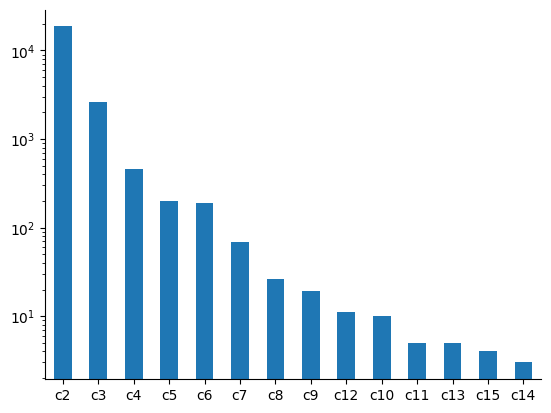

In [108]:
cx = cyclic_assemblies_variants.plot(kind="bar")
cx.spines['top'].set_visible(False)
cx.spines['right'].set_visible(False)
cx.set_yscale('log')
cx.set_xticklabels(cx.get_xticklabels(), rotation=0)

In [109]:
# Show all the dihedral assemblies variants
dihedral_assemblies_variants = dihedral_assemblies['PRIMARY_SYM'].value_counts()
dihedral_assemblies_variants

d2     3614
d3     1257
d4      472
d5      140
d6      103
d7       70
d8       19
d9        4
d17       2
d10       1
d16       1
d12       1
d24       1
Name: PRIMARY_SYM, dtype: int64

[Text(0, 0, 'd2'),
 Text(1, 0, 'd3'),
 Text(2, 0, 'd4'),
 Text(3, 0, 'd5'),
 Text(4, 0, 'd6'),
 Text(5, 0, 'd7'),
 Text(6, 0, 'd8'),
 Text(7, 0, 'd9'),
 Text(8, 0, 'd17'),
 Text(9, 0, 'd10'),
 Text(10, 0, 'd16'),
 Text(11, 0, 'd12'),
 Text(12, 0, 'd24')]

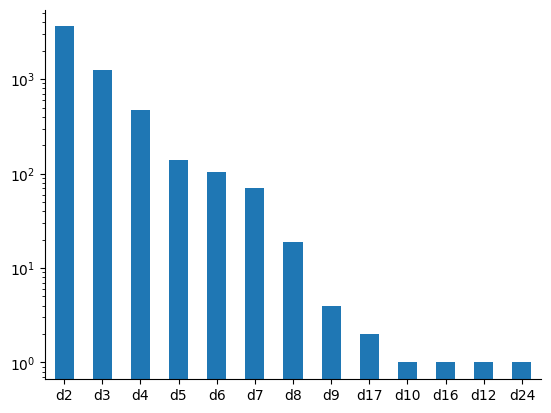

In [110]:
dx = dihedral_assemblies_variants.plot(kind="bar")
# dx.set_title("Dihedral (Dn) symmetry groups detected")
dx.spines['top'].set_visible(False)
dx.spines['right'].set_visible(False)
dx.set_yscale('log')
dx.set_xticklabels(dx.get_xticklabels(), rotation=0)

## 5.3) Listing assemblies with inconsistent symmetries

We can list assemblies where the symmetry data is inconsistent between different instances of the same assembly. This can highlight potential annotation errors, or genuinely interesting assemblies.

In [111]:
df_inconsistent_symmetry = df_protein[df_protein['CONSISTENT_SYMMETRY'] == False]
# Number of unique assemblies containing members with inconsistent symmetry
df_inconsistent_symmetry.shape[0]

1651

In [112]:
# df2 = df_inconsistent_symmetry.copy()
# df2["ASYM_ASSEMBLIES"] = df2.apply(lambda row: ui.get_asymmetrical_assemblies(row["PREFERED_ASSEMBLIES"], row["SYMMETRY_OPS"]), axis=1)
# df2["EXTENDED_SYMMETRY_OPS"] = df2.apply(lambda row: ui.get_extended_symmetry_operators(row["PREFERED_ASSEMBLIES"], row["SYMMETRY_OPS"]), axis=1)

In [113]:
# df3 = df2[["ASSEMBLY_STRING", "PDB_COMPLEX_ID", "ASSEMBLY_NAME", "PRIMARY_SYM", "ALL_SYM", "ASYM_ASSEMBLIES", "EXTENDED_SYMMETRY_OPS"]]
# df3.reset_index()
# df3.to_csv("inconsistent_symmetry.csv", index=False)

We can also investigate the data by explicitly excluding asymmetric C1 instance.

In [114]:
# Assemblies with inconsistent symmetry operators (excluding asymmetric C1)
df_protein[(df_protein["CONSISTENT_SYMMETRY"] == False) & (~df_protein["SYMMETRY_OPS"].str.contains("no-sym"))]

,ASSEMBLY_STRING,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING_WITH_UNP_NUMBERING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,hasChimericChains,...,hasRNAComponent,hasDNAComponent,ASSEMBLY_POLYMERS,hasAllUNPMapping,hasAnyUNPMapping,SYMMETRY_OPS,CONSISTENT_SYMMETRY,SYM_NUM,ALL_SYM,PRIMARY_SYM
267,A0A059VAZ3_6,fd337aa8038a465b0e6601a643aac684,"A0A059VAZ3_6|242_793,A0A059VAZ3_6|491_793",PDB-CPX-100268,nan,Lon protease,protein name from UniProt,"4ypl_1,4ypm_1","4ypl_1,4ypm_1",False,...,False,False,protein,True,True,"c3,c6",False,2,"c6, c3",c3
1708,A0A0H2ZIZ8_2,25307304da5e31a99b705845bb427197,A0A0H2ZIZ8_2|1_71,PDB-CPX-101709,nan,Carbon storage regulator,protein name from UniProt,"4k59_1,4krw_1","4k59_1,4krw_1",False,...,False,False,protein,True,True,"c3,c2",False,2,"c3, c2",c3
2934,A0A140JXP0_2,50e96bf202e66f595a370492186bbd9e,A0A140JXP0_2|24_139:141_149,PDB-CPX-102935,nan,Zona pellucida sperm-binding protein 1,protein name from UniProt,"6gf6_1,6gf7_1,6gf8_1,6gf8_2","6gf6_1,6gf7_1,6gf8_1",False,...,False,False,protein,True,True,"c3,c3,c2",False,2,"c3, c2",c3
4117,A0A290U7C4_4,bccdc5368a21f5dda1b344c789f6ddc7,A0A290U7C4_4|1_1306,PDB-CPX-104118,nan,Disease resistance protein Roq1,protein name from UniProt,"7jlv_1,7jlx_1","7jlv_1,7jlx_1",False,...,False,False,protein,True,True,"c4,c2",False,2,"c4, c2",c4
4118,A0A290WPI2_4,086c0a4db5c517abe7c43d2a02b5f8d6,"A0A290WPI2_4|7_803,A0A290WPI2_4|1_803",PDB-CPX-104119,nan,Vegetative insecticidal protein,protein name from UniProt,"6v1v_1,6yrf_1,6yrg_1,7ntx_1","6v1v_1,6yrf_1,6yrg_1,7ntx_1",False,...,False,False,protein,True,True,"c2,c2,c4,c4",False,2,"c4, c2",c2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92296,Q9LNF2_3,d169dfce84fffa4df80edef256d6350a,Q9LNF2_3|27_176,PDB-CPX-192297,nan,Pectinesterase inhibitor 1,protein name from UniProt,"1x8z_3,1x90_3,1x90_4","1x8z_3,1x90_3",False,...,False,False,protein,True,True,"c2,c3",False,2,"c3, c2",c2
93610,Q9U6B8_6,f6b9809a58027be10d8e00f475146dc2,"Q9U6B8_6|133_341,Q9U6B8_6|132_341",PDB-CPX-193611,nan,Calcium release-activated calcium channel prot...,protein name from UniProt,"4hkr_1,4hks_1,6aki_1,6aki_2,6bbf_1,6bbf_2,6bbf...","4hkr_1,4hks_1,6aki_1,6bbf_1,6bbg_1,6bbh_1,6bbi_1",False,...,False,False,protein,True,True,"c3,c3,c6,c6,c6,c6,c6",False,2,"c6, c3",c6
93753,Q9UHL4_2,86fa5a17c34c5cc152b5bb38980b0564,"Q9UHL4_2|28_492,Q9UHL4_2|27_492",PDB-CPX-193754,nan,Dipeptidyl peptidase 2,protein name from UniProt,"3jyh_1,3jyh_2,3n0t_1,3n0t_2,4ebb_3,4ebb_4","3jyh_1,3n0t_1,4ebb_3",False,...,False,False,protein,True,True,"c2,c2,c3",False,2,"c3, c2",c2
94181,"Q9V2S9_8,Q9V2T8_8",4f1bb6290046a704e2c01e5156092bb5,"Q9V2S9_8|1_559,Q9V2T8_8|1_554",PDB-CPX-194182,nan,Thermosome subunit alpha and Thermosome subuni...,heterodimer,"4xcg_1,4xci_1","4xcg_1,4xci_1",False,...,False,False,protein,True,True,"d4,d8",False,2,"d8, d4",d4


## Conclusion

This work provides an archive-wide analysis of assemblies in the PDB archive and demonstrates the power of mapping individual components of assemblies to external databases. Our new approach allows the otherwise complex aggregation of assemblies. With the help of mappings to external databases, it also became possible to name over 80% of assemblies in the PDB, representing over 90% of PDB entries. These names allow users of PDBe to find complexes that previously could only be found by relying on the title of the PDB entry or listing all the complex components. Searching by title or listing components is likely to lead to incomplete and inconsistent search results due to the heterogeneity of assemblies in the PDB archive. We are making the complexes name list and mapping data files available to the community to aid in analysing and identifying macromolecular complexes.

## Authors

* Sri Appasamy
* Mihaly Varadi

### Last updated March 2023